In [1]:
#Bartu Atabek 21602229
#Utku Gorkem Erturk 21502497
#Cagla Sozen 21602547

import numpy as np
from PIL import Image
import glob
import math
import torch
import torchvision.models as models
import torch.nn as nn
import torch.utils.data as tdata
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import skimage.io
from tqdm import tqdm
import selective_search as ss
from torchvision.transforms import functional as F
from natsort import natsorted
import itertools
import ntpath
import matplotlib.patches as mpatches

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def preprocess_data(image):
    image = image.convert('RGB')
    image = np.asarray(image)
    row = image.shape[0]
    col = image.shape[1]
    if(row > col):
        right = math.ceil((row-col)/2)
        left = math.floor((row-col)/2)
        image = np.pad(image, ((0,0),(left,right),(0,0)), 'constant')
    else:
        top = math.ceil((col-row)/2)
        bottom = math.floor((col-row)/2)
        image = np.pad(image, ((top,bottom),(0,0),(0,0)), 'constant')
    image = np.array(Image.fromarray(image).resize((224,224)))
    image = image / 255
    image[:,:,0] = (image[:,:,0] - 0.485) / 0.229
    image[:,:,1] = (image[:,:,1] - 0.456) / 0.224
    image[:,:,2] = (image[:,:,2] -  0.406) / 0.225
    image = image.astype('float32')
    return image

In [4]:
#load and preprocess the data
train_images = []
train_labels = []
filenames = []
for idx,dirname in enumerate(glob.glob('cs484_project_data/train/*')):
    filenames.append(ntpath.basename(dirname))
    for filename in glob.glob(dirname +"/*"):
        image = Image.open(filename)
        image = preprocess_data(image)
        train_images.append(image)
        train_labels.append(idx)

In [5]:
test_truth_data = pd.read_csv("cs484_project_data/test/bounding_box.txt", header=None)
test_images = []
test_labels = []
test_image_fnames= glob.glob('cs484_project_data/test/images/*')
test_image_fnames = natsorted(test_image_fnames)
for i,filename in enumerate(test_image_fnames):
    test_labels.append(filenames.index(test_truth_data[0][i]))
    image = Image.open(filename)
    test_images.append(image)

In [6]:
resnet50 = models.resnet50(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(resnet50.children())[:-1]).eval().to(device)

feature_arr = []
for img in tqdm(train_images):
    # we append an augmented dimension to indicate batch_size, which is one
    image = np.reshape(img, [1, 224, 224, 3])
    # model takes as input images of size [batch_size, 3, im_height, im_width]
    image = np.transpose(image, [0, 3, 1, 2])
    # convert the Numpy image to torch.FloatTensor
    image = torch.from_numpy(image).to(device)
    # extract features
    feature_vector = feature_extractor(image)
    # convert the features of type torch.FloatTensor to a Numpy array
    # so that you can either work with them within the sklearn environment # or save them as .mat files
    feature_vector = feature_vector.cpu().detach().numpy()
    #feature_vector = feature_vector / np.linalg.norm(feature_vector)
    feature_arr.append(feature_vector.squeeze())

100%|██████████| 398/398 [00:09<00:00, 40.36it/s]


In [7]:
feature_arr = np.reshape(feature_arr, [398,2048])
tensor_x = torch.from_numpy(feature_arr)
tensor_y = torch.from_numpy(np.array(train_labels)).type("torch.LongTensor")

train_data = tdata.TensorDataset(tensor_x, tensor_y)
train_dataloader = tdata.DataLoader(train_data, batch_size=32, shuffle=True)

In [8]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(2048, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out) 
        out = self.fc2(out)
        return out

model = FeedForward(1375).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [10]:
for epoch in range(5):  # loop over the dataset multiple times    
    running_loss = 0.0
    running_corrects = 0
    for i, (features,labels) in enumerate(train_dataloader):
        features = features.to(device)
        labels = labels.to(device)
        
        # forward + backward + optimize
        outputs = model(features)
        
        #print(label)
        loss = criterion(outputs.to(device), labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * features.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)
    print('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc))
print('Finished Training')

loss: 1.0828, acc: 0.6884
loss: 0.0854, acc: 0.9749
loss: 0.0379, acc: 0.9925
loss: 0.0171, acc: 0.9950
loss: 0.0046, acc: 1.0000
Finished Training


In [11]:
box_proposal_list = []
for image in tqdm(test_images):
    box_proposal_list.append(ss.selective_search(image, mode='single', random=False))
box_proposal_list = np.array(box_proposal_list)

100%|██████████| 100/100 [09:53<00:00,  5.94s/it]


In [12]:
#Unused section only use to filter boxes to improve speed 
# box_proposal_list_filtered = []
# for boxes in box_proposal_list:
#      box_proposal_list_filtered.append(ss.box_filter(boxes, min_size=100))
# box_proposal_list = box_proposal_list_filtered


In [13]:
from operator import itemgetter
images_box_class = []
for image,box_proposals in tqdm(zip(test_images,box_proposal_list),total=len(test_images)):
    max_preds = []
    for box in box_proposals:
        cropped_img = image.crop(box)
        cropped_img = preprocess_data(cropped_img)
        cropped_img = np.reshape(cropped_img, [1, 224, 224, 3])
        cropped_img = np.transpose(cropped_img, [0, 3, 1, 2])
        cropped_img_tensor = torch.from_numpy(cropped_img).to(device)
        feature = feature_extractor(cropped_img_tensor)
        pred_logits_tensor = model(feature.view(1,2048))
        pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
        max_preds.append({"class": np.argmax(pred_probs[0]),"prob": max(pred_probs[0]), "box": box})
    max_item = max(max_preds, key=itemgetter('prob'))
    images_box_class.append({"class": max_item['class'],"box": max_item['box'], "prob": max_item['prob']})

100%|██████████| 100/100 [15:26<00:00,  9.26s/it]


In [14]:
def get_confusion_matrix(ground_truth, predictions, labels):
    label_no = len(labels)
    conf_mat = np.zeros((label_no, label_no),dtype=int);
    
    for i in range(len(predictions)):
        true_val = ground_truth[i]
        prediction = predictions[i]
        conf_mat[true_val][prediction] = conf_mat[true_val][prediction] + 1
    return conf_mat

In [15]:
classes_c=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
preds = [item['class'] for item in images_box_class]
cnf_matrix = get_confusion_matrix(test_labels, preds, classes_c)

In [16]:
def plot_conf_mat(cm, classes):
    
    for i in range(len(classes)):
        classes[i] = str(classes[i])
        
    plt.imshow(cm, cmap=plt.cm.Reds)
    plt.title("Confusion Matrix for Class Predictions")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    max_val = cm.max()/2

    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        curr =  cm[i, j]      
        
        if curr > max_val:
            txt_col = "white"
        else:
            txt_col = "black"
                                  
        plt.text(j, i, format(curr, 'd'),
                 horizontalalignment="center",
                 color= txt_col)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

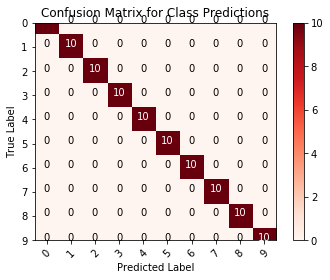

In [17]:
plt.figure()
plot_conf_mat(cnf_matrix, classes_c)
plt.savefig('confusion-matrix.png')

In [18]:
def get_statistics(cm, labels):
    tp_arr = np.zeros(len(labels))
    fp_arr = np.zeros(len(labels))
    fn_arr = np.zeros(len(labels))
    tn_arr = np.zeros(len(labels))
    
    sum_false_pos = cm.sum(axis=0)
    sum_false_neg = cm.sum(axis=1)
    
    total = sum_false_neg.sum()
    prec = 0
    recall = 0

    for label in labels:
        prec = 0
        recall = 0
        label = int(label)
        tp_arr[label] = cm[label][label]
        fp_arr[label] = sum_false_pos[label] - tp_arr[label]
        fn_arr[label] = sum_false_neg[label] - tp_arr[label]
        tn_arr[label] = total - fp_arr[label] - fn_arr[label] - tp_arr[label]
        
        prec = tp_arr[label] / (tp_arr[label] + fp_arr[label])
        recall = tp_arr[label] / (tp_arr[label] + fn_arr[label])
        
        print("Precision for class " + str(label), prec)
        print("Recall for class " + str(label), recall)

    acc = ((tp_arr.sum() ) *100) / total
    print("Overall Accuracy " , acc)

In [19]:
get_statistics(cnf_matrix, classes_c)

Precision for class 0 1.0
Recall for class 0 1.0
Precision for class 1 1.0
Recall for class 1 1.0
Precision for class 2 1.0
Recall for class 2 1.0
Precision for class 3 1.0
Recall for class 3 1.0
Precision for class 4 1.0
Recall for class 4 1.0
Precision for class 5 1.0
Recall for class 5 1.0
Precision for class 6 1.0
Recall for class 6 1.0
Precision for class 7 1.0
Recall for class 7 1.0
Precision for class 8 1.0
Recall for class 8 1.0
Precision for class 9 1.0
Recall for class 9 1.0
Overall Accuracy  100.0


In [20]:
overlap_ratio_arr = []
true_box_arr = []
for pred, (index,truth) in zip(images_box_class, test_truth_data.iterrows()):
    pred_box = pred['box']
    min_x = max(pred_box[0],truth[1])
    min_y = max(pred_box[1],truth[2])
    max_x = min(pred_box[2],truth[3])
    max_y = min(pred_box[3],truth[4])
    true_box_arr.append([truth[1],truth[2],truth[3],truth[4]])
    pred_area = (pred_box[2] - pred_box[0] + 1)*(pred_box[3] - pred_box[1] + 1) 
    truth_area = (truth[3] - truth[1] + 1)*(truth[4] - truth[2] + 1)
    intersection_area = 0
    
    if(min_x < max_x and min_y < max_y):
        intersection_area = (max_x - min_x + 1)*(max_y - min_y + 1)
    overlap_ratio_arr.append(intersection_area/(pred_area+truth_area-intersection_area))

In [21]:
for label, overlap_ratio in zip(test_labels, overlap_ratio_arr):
    print('Class ' + str(label) +':'+ str(overlap_ratio))

Class 4:0.9718456725755996
Class 4:0.8378133494412564
Class 4:0.3881756267207651
Class 4:0.9567798406881304
Class 4:0.9459605530508788
Class 4:0.8338008415147266
Class 4:0.7591489361702127
Class 4:0.5857691928648862
Class 4:0.7318916297874666
Class 4:0.9171096010226738
Class 9:0.6997089742828295
Class 9:0.8122850122850123
Class 9:0.21313897050468322
Class 9:0.47409436446256426
Class 9:0.46009568165256787
Class 9:0.3338759269307289
Class 9:0.2987942823734759
Class 9:0.6205173688100517
Class 9:0.7439507597614926
Class 9:0.19242560015092203
Class 5:0.2667702446603268
Class 5:0.7816460222559144
Class 5:0.9505630456481703
Class 5:0.2134351079873659
Class 5:0.6976011735266201
Class 5:0.9390751666200768
Class 5:0.22019867549668873
Class 5:0.3917910447761194
Class 5:0.48841306073838825
Class 5:0.8469866747425803
Class 1:0.23042307605769013
Class 1:0.14518329070758737
Class 1:0.928941036178957
Class 1:0.22156521739130436
Class 1:0.6878270567041262
Class 1:0.1311186005456588
Class 1:0.2626049717

In [22]:
total_correct_pred = 0
for pred, test_label,overlap_ratio in zip(preds,test_labels,overlap_ratio_arr):
    if (pred == test_label) and overlap_ratio >= 0.5:
        total_correct_pred = total_correct_pred + 1
        
localization_acc = total_correct_pred/len(test_images)
print("Overall Localization Accuracy " , localization_acc)

Overall Localization Accuracy  0.45


In [23]:
def getOrganizedIndexes(correct_num, incorrect_num, test_labels,overlap_ratio_arr):
    total_num = incorrect_num + correct_num
    pic_index = []
    correct_indexes = np.where(np.array(overlap_ratio_arr) >=0.5)
    incorrect_indexes = np.where(np.array(overlap_ratio_arr) < 0.5)
    for class_c in range(10):
        incorrect_num_in = incorrect_num
        correct_num_in = correct_num

        curr_correct_num = 0
        curr_incorrect_num = 0
        curr_class_i = []
        class_c_correct = [index for index in correct_indexes[0] if test_labels[index] == class_c]
        class_c_incorrect = [index for index in incorrect_indexes[0] if test_labels[index] == class_c]
        if correct_num > len(class_c_correct):
            incorrect_num_in  = incorrect_num + correct_num - len(class_c_correct)

        if incorrect_num > len(class_c_incorrect):
            correct_num_in  = correct_num + incorrect_num - len(class_c_incorrect)

        for index in class_c_correct:
            if curr_correct_num == correct_num_in:
                break
            curr_correct_num = curr_correct_num + 1
            curr_class_i.append((index,True))

        for index in class_c_incorrect:
            if curr_incorrect_num == incorrect_num_in:
                break
            curr_incorrect_num = curr_incorrect_num + 1
            curr_class_i.append((index,False))
        pic_index.append(curr_class_i)
    return pic_index

pic_index = getOrganizedIndexes(1, 1, test_labels,overlap_ratio_arr)

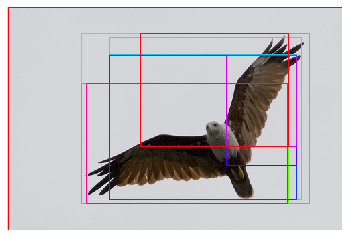

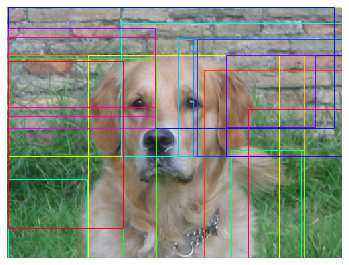

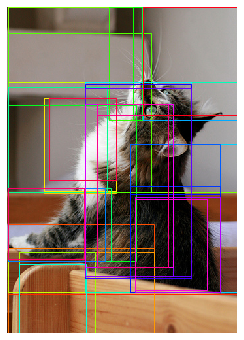

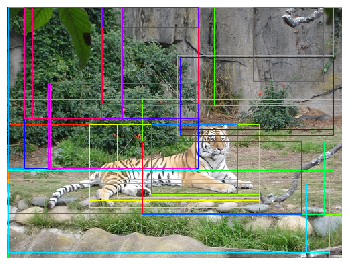

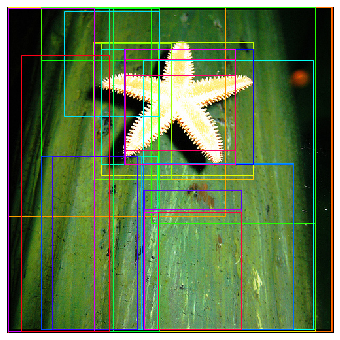

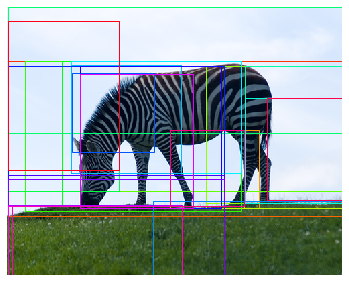

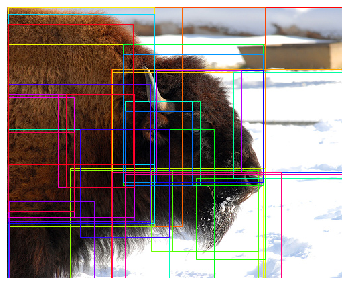

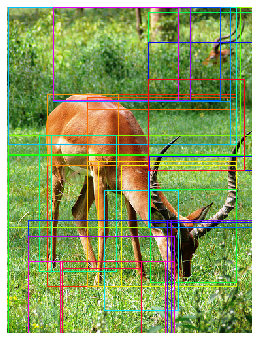

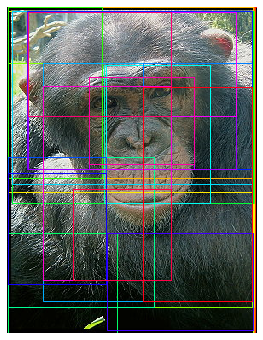

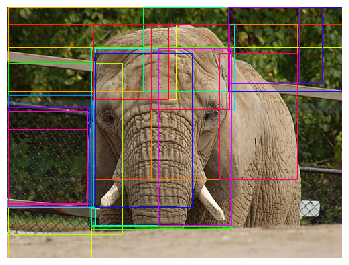

In [24]:
for indexes in pic_index:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(test_images[indexes[0][0]])
    boxes = box_proposal_list[indexes[0][0]]
    boxes_filtered = ss.box_filter(boxes, min_size=100)
    cmap = plt.cm.get_cmap('hsv', len(boxes_filtered))
    for i,(x1, y1, x2, y2) in enumerate(boxes_filtered):
        bbox = mpatches.Rectangle(
            (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor=cmap(i), linewidth=1)
        ax.add_patch(bbox)
        

    plt.axis('off')
    #plt.savefig(str(test_labels[indexes[0][0]])+'-proposal.png')
    plt.show()
    

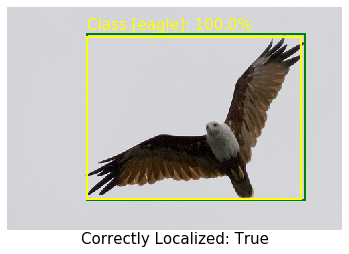

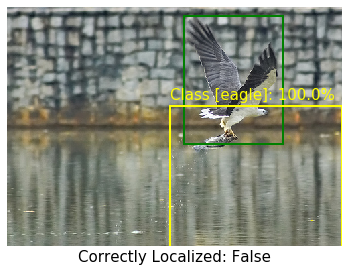

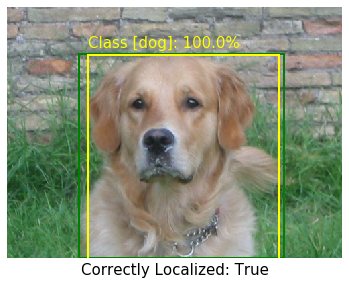

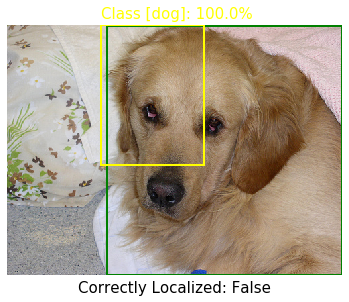

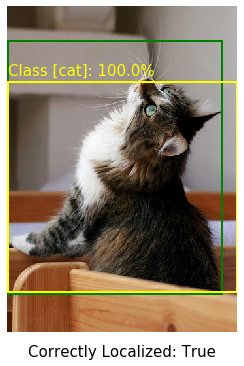

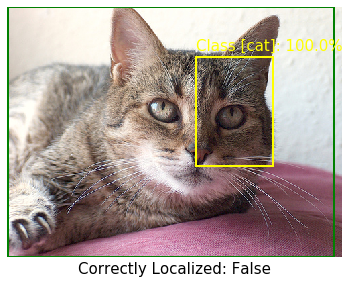

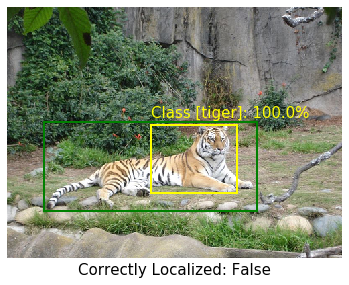

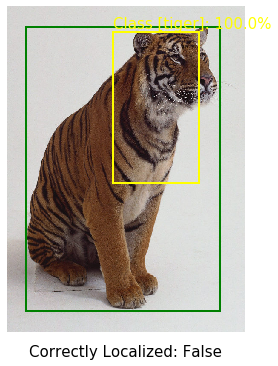

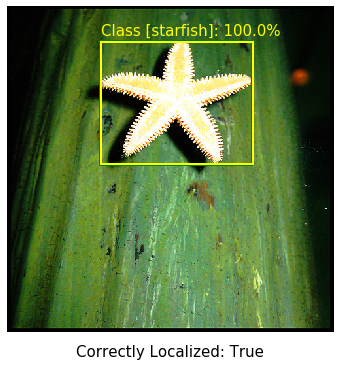

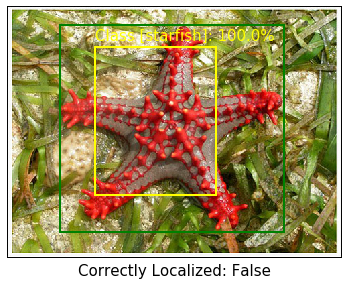

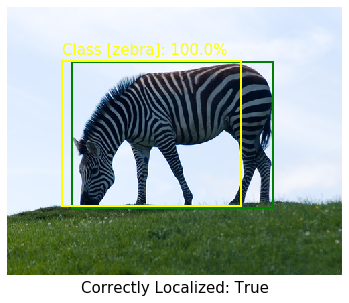

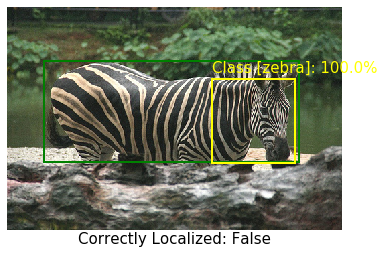

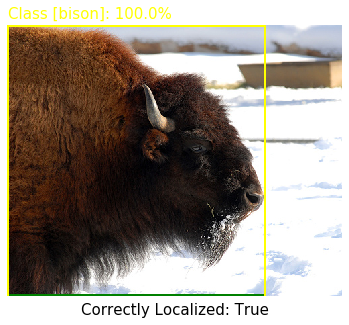

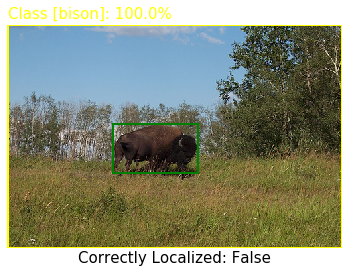

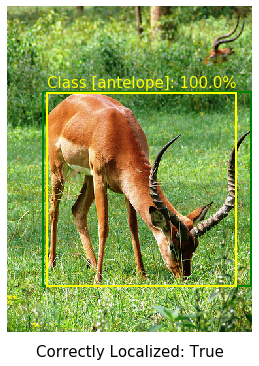

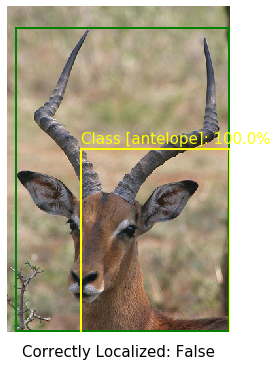

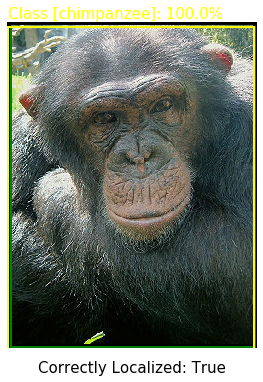

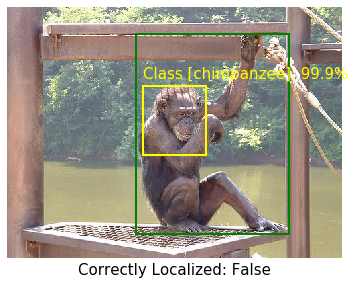

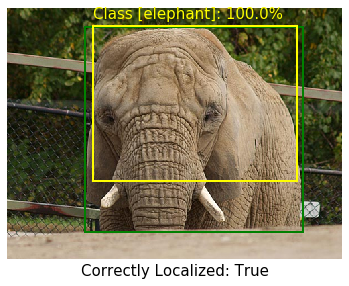

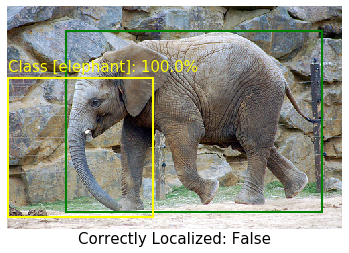

In [25]:
class_names = ['eagle', 'dog', 'cat', 'tiger','starfish', 'zebra', 'bison','antelope','chimpanzee','elephant']
for class_c,indexes in enumerate(pic_index):
    for i in indexes:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(test_images[i[0]])
        img_bc = images_box_class[i[0]]
        box = img_bc['box']
        prob = img_bc['prob']

        x1, y1, x2, y2 = true_box_arr[i[0]]
        bbox_true = mpatches.Rectangle(
            (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(bbox_true)
        
        x1, y1, x2, y2 = box
        bbox_pred = mpatches.Rectangle(
            (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(bbox_pred)
        plt.text(x1, y1-10,'Class [' + class_names[class_c] + ']: ' + '{:.1%}'.format(prob), color='yellow', fontsize=15)
        
        ax.set_title('Correctly Localized: '+ str(i[1]), y=-0.09, fontsize=15)    
        plt.axis('off')
        #plt.savefig(class_names[class_c]+'-localization-'+str(i[1])+'.png')
        plt.show()



